## Convert video in DVS images

In [18]:
#load modules
import numpy as np
from matplotlib import pyplot as plt
import data_utils
import tiffcapture as tc 
import cv2
from PIL import Image
import matplotlib.animation as animation

In [2]:
#set input and output paths
datasetpath='C:/Users/Gemma/Desktop/TubingenSecondment/dataset'
outputpath='C:/Users/Gemma/Desktop/TubingenSecondment/dataset'

#input images
train_image_path=datasetpath+"/train.tiff"
test_image_path=datasetpath+"/test.tiff"

## Functions

In [4]:
def form_tiff_to_listarray(filename):
    print("Convert tiff file")
    tiff = tc.opentiff(filename)
    listarray=[]
    for img in tiff:
        listarray.append(img)
    listarray_array=np.asarray(listarray)
    return listarray_array

In [5]:
#input video array frame, height, width
#DHW - (depth, height, width) ????
def DVSimages(video,thrP,thrN):
    video_shape=  (video.shape)[1:3]
    video_length=  (video.shape)[0] 
    state_img=video[0,:,:]
    DVSimg=np.zeros(video_shape, dtype=np.int16)
    DVSvideo=[]
    DVSvideo.append(DVSimg)

    for i in range(video_length):
        
        img=np.int16(video[i,:,:])
        #check if the changes surpass a fix threshold (different thresholds for ON and OFF)
        tmp=img-state_img

        onEvents=tmp>thrP
        offEvents=tmp<-thrN
        
        #DVS image
        DVSimg=np.zeros(video_shape, dtype=np.int16)
        DVSimg[onEvents]=1
        DVSimg[offEvents]=-1
        DVSvideo.append(DVSimg)
        
        state_img[onEvents]=img[onEvents]
        state_img[offEvents]=img[offEvents]
    
    DVSvideo_array=np.asarray(DVSvideo)

    return DVSvideo_array

## Main

In [40]:
thrP_perc=0.01# threshold in %
thrN_perc=0.01#
min_value=0
max_value=255
thrP=thrP_perc*(max_value-min_value)#positive threshold in DN 
thrN=thrN_perc*(max_value-min_value)#negative threshold in DN (positive value)
print("Positive threshold:",thrP)
print("Negative threshold:",thrN)

('Positive threshold:', 2.5500000000000003)
('Negative threshold:', 2.5500000000000003)


In [8]:
#import video 
#TEST
video_test=form_tiff_to_listarray(test_image_path)
print("number video frame",video_test.shape)
#TRAIN
video_train=form_tiff_to_listarray(train_image_path)
print("number video frame",video_train.shape)

Convert tiff file
('number video frame', (749L, 64L, 64L))
Convert tiff file
('number video frame', (16199L, 64L, 64L))


255
0


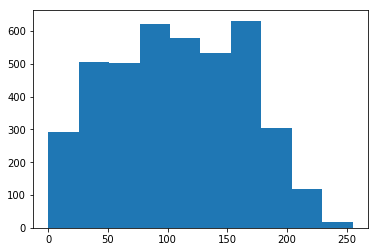

In [9]:
#statistics
plt.hist(video_test[0,:,:].flatten())
print video_test.max()
print video_test.min()

[0 0 0 ..., 0 0 0]


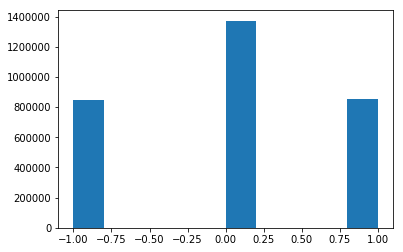

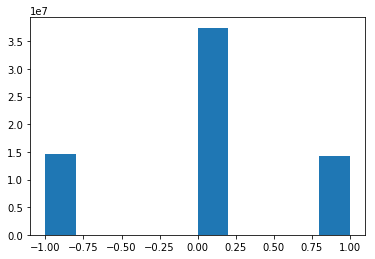

In [41]:
#TEST
DVSvideo_test=DVSimages(video_test,thrP,thrN)
#TRAIN
DVSvideo_train=DVSimages(video_train,thrP,thrN)   

plt.hist(DVSvideo_test.flatten())
plt.figure()
plt.hist(DVSvideo_train.flatten())

print DVSvideo_test[0,:,:].flatten()

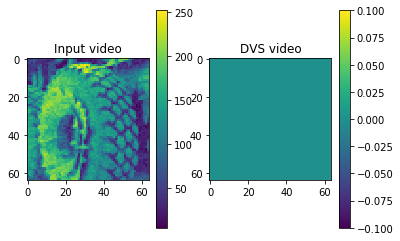

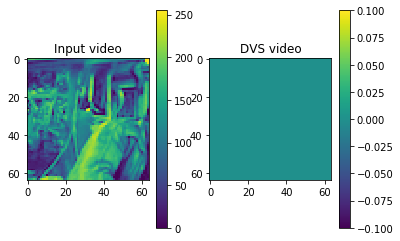

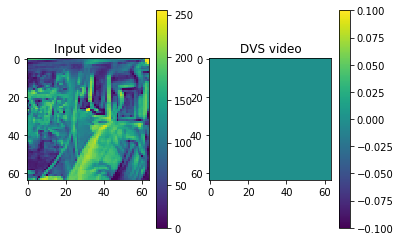

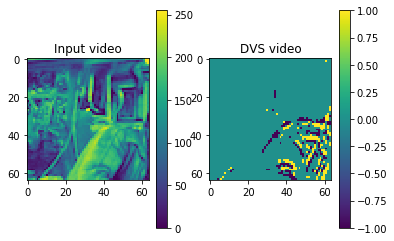

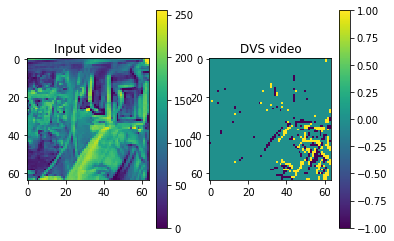

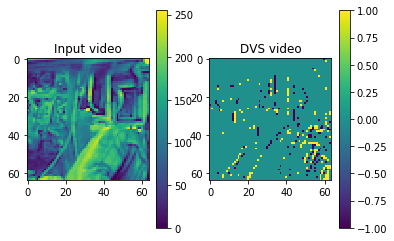

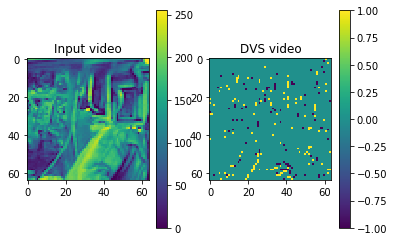

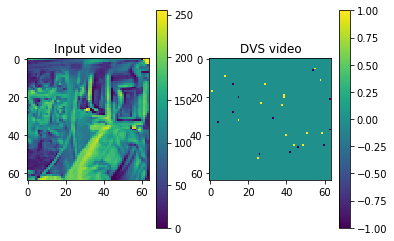

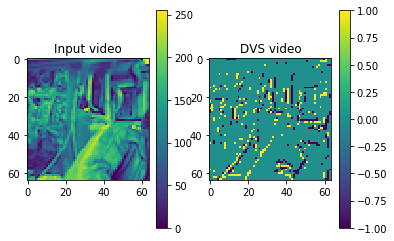

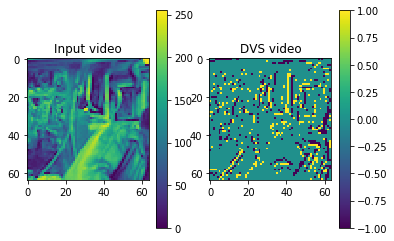

In [12]:
#Plot images
num_of_frame=10
array1=video_test
array2=DVSvideo_test
title1="Input video"
title2="DVS video"


for i in range(num_of_frame):
        plt.figure()
        plt.subplot(121)
        plt.imshow(array1[i,:,:])
        plt.title(title1)
        plt.colorbar()
        plt.subplot(122)
        plt.title(title2)
        plt.imshow(array2[i,:,:])
        plt.colorbar()

In [22]:
def create_DVSvideo(filename,data,fps):
    print("Create video")
    size= (data.shape) [1:3]
    writer = cv2.VideoWriter(filename,cv2.VideoWriter_fourcc(*'XVID'),fps,size,True)
    for i in range(len(data)):
        frame=(data[i,:,:]+1)*(255/2)
        frame=np.stack([frame,frame,frame],axis=2)
        writer.write(np.uint8(frame))         
    return

In [42]:
#Save .avi video
train_image_output_path=(train_image_path.replace(".tiff", "")+"_DVS_"+str(int(thrP_perc*100))+".avi").replace(datasetpath,outputpath)
test_image_output_path=(test_image_path.replace(".tiff", "")+"_DVS_"+str(int(thrP_perc*100))+".avi").replace(datasetpath,outputpath)

fps=30

print(train_image_output_path)
print(test_image_output_path)
create_DVSvideo(train_image_output_path,DVSvideo_train,fps)
create_DVSvideo(test_image_output_path,DVSvideo_test,fps)

C:/Users/Gemma/Desktop/TubingenSecondment/dataset/train_DVS_1.avi
C:/Users/Gemma/Desktop/TubingenSecondment/dataset/test_DVS_1.avi
Create video
Create video


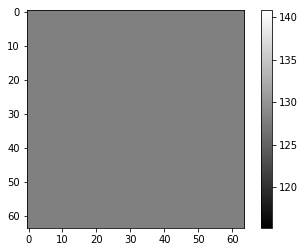

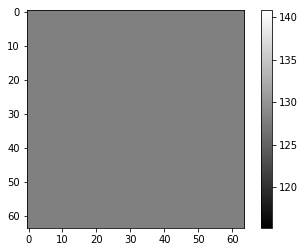

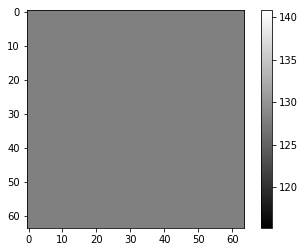

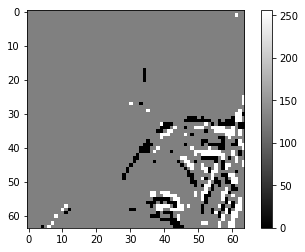

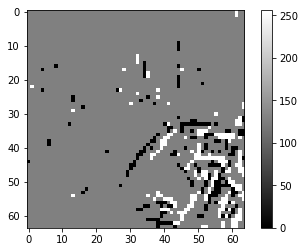

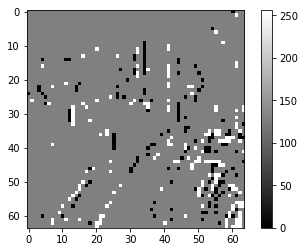

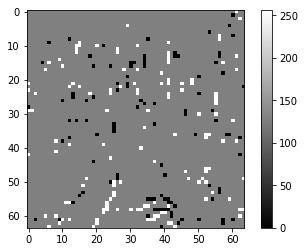

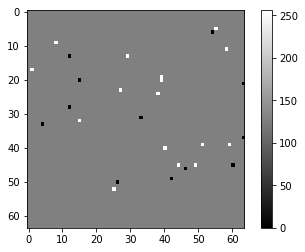

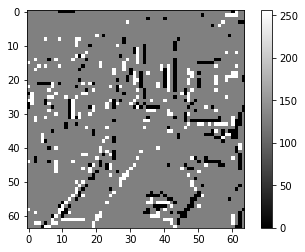

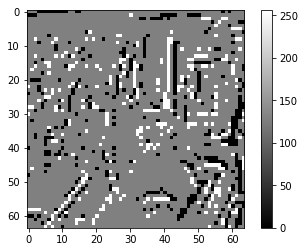

In [26]:
#Plot images
num_of_frame=10

for i in range(num_of_frame):
    frame=(DVSvideo_test[i,:,:]+1)*(256/2)
    plt.figure()
    plt.imshow(frame,cmap='gray')
    plt.colorbar()